# Use Keras to break captcha

**Captcha** is written in python generated verification code library, which supports the dynamic generation of image verification code and voice verification code, we use it to generate the image verification code to generate model training data and verification information. And through Keras generator function to directly use the captcha generated images, without the need to pre-data generated in the file.

![captcha](https://imgur.com/kNdhQ06.png)

## Captcha

The format of captcha is capital letters and digit

In [1]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random
import string

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


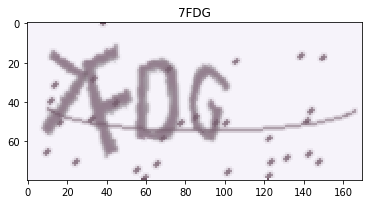

In [2]:
characters = string.digits + string.ascii_uppercase
print(characters) 

# Captcha Generate image width and height, 
# with a few letters to form a string and the number of letters that will be used
width, height, n_len, n_class = 170, 80, 4, len(characters)

# Set captcha image length and width
generator = ImageCaptcha(width=width, height=height) 

# Produce a 4 letter captcha
random_str = ''.join([random.choice(characters) for j in range(4)]) 
img = generator.generate_image(random_str)

plt.imshow(img)
plt.title(random_str)
plt.show()

## Data Generator

When training the model, we can choose two ways to generate our training data. One is to generate tens of thousands of images one at a time, and then start training. One is to define a data generator and then use the `fit_generator` function to train.

The advantage of the first method is that when the training graphics card utilization is high, if you need regular reference can be generated at one time, multiple use; The benefits of the second method is that you do not need to generate large amounts of data, the training process can be used The CPU generates the data, and one more benefit is that you can generate data indefinitely.

X: (batch_size，height，width，3)

y: 4(batch_size，n_class), to numpy format (n_len，batch_size，n_class)
For example, if a batch of 32 samples is generated, there are 36 characters in the verification code and its length is 4 digits. Then its shape is 4 (32, 36) and can also be called (4, 32, 36).

ps. Please pay special attention to y data structure (4, 32, 36) is the output corresponding to the network 4 softmax

In [3]:
def gen(batch_size=32):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    generator = ImageCaptcha(width=width, height=height)
    while True:
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            X[i] = generator.generate_image(random_str)
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
        yield X, y

The above example is an example of how to generate image data infinitely. We will use this generator to generate image data to train our model.

## Use Generator

The generator is easy to use, just use the next () function. The following is an example, generating 32 image data, and then displaying the first image data. Of course, here we also decode the generated One-Hot encoded data, first turn it into a numpy array, and then take the position of the largest number of 36 characters, because the neural network will output a 36-character probability, And then the probability of the four characters of the largest number conversion string.

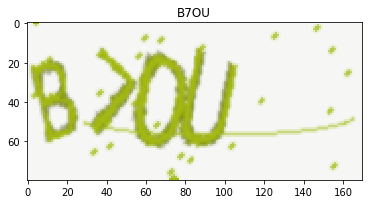

In [16]:
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])

# Generate a batch size of 2 data
X, y = next(gen(2)) 

plt.imshow(X[0])
plt.title(decode(y))
plt.show()

## NN Structure

The feature extraction section uses two convolutions, a pooling structure, which is the structure of the learning VGG16. After that, we expand it, and then add Dropout, try to avoid overfitting the problem, and finally connect four classifiers, each classifier is 36 neurons, the output probability of 36 characters. This network model is more special in the design of the last four classifiers.

In [23]:
from keras.models import *
from keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor

# Produce a convolutional network with four blocks
for i in range(4):
    x = Conv2D(32*2**i, (3, 3), activation='relu')(x)
    x = Conv2D(32*2**i, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    
x = Flatten()(x)
x = Dropout(0.25)(x)

# Multi-output model, the captcha this time is 4 letters (fixed length), 
# so we use four corresponding 'softmax' to predict the output of four letters
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(4)]

model = Model(inputs=input_tensor, outputs=x)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 80, 170, 3)   0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 78, 168, 32)  896         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 76, 166, 32)  9248        conv2d_9[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 38, 83, 32)   0           conv2d_10[0][0]                  
__________________________________________________________________________________________________
conv2d_11 

In [24]:
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

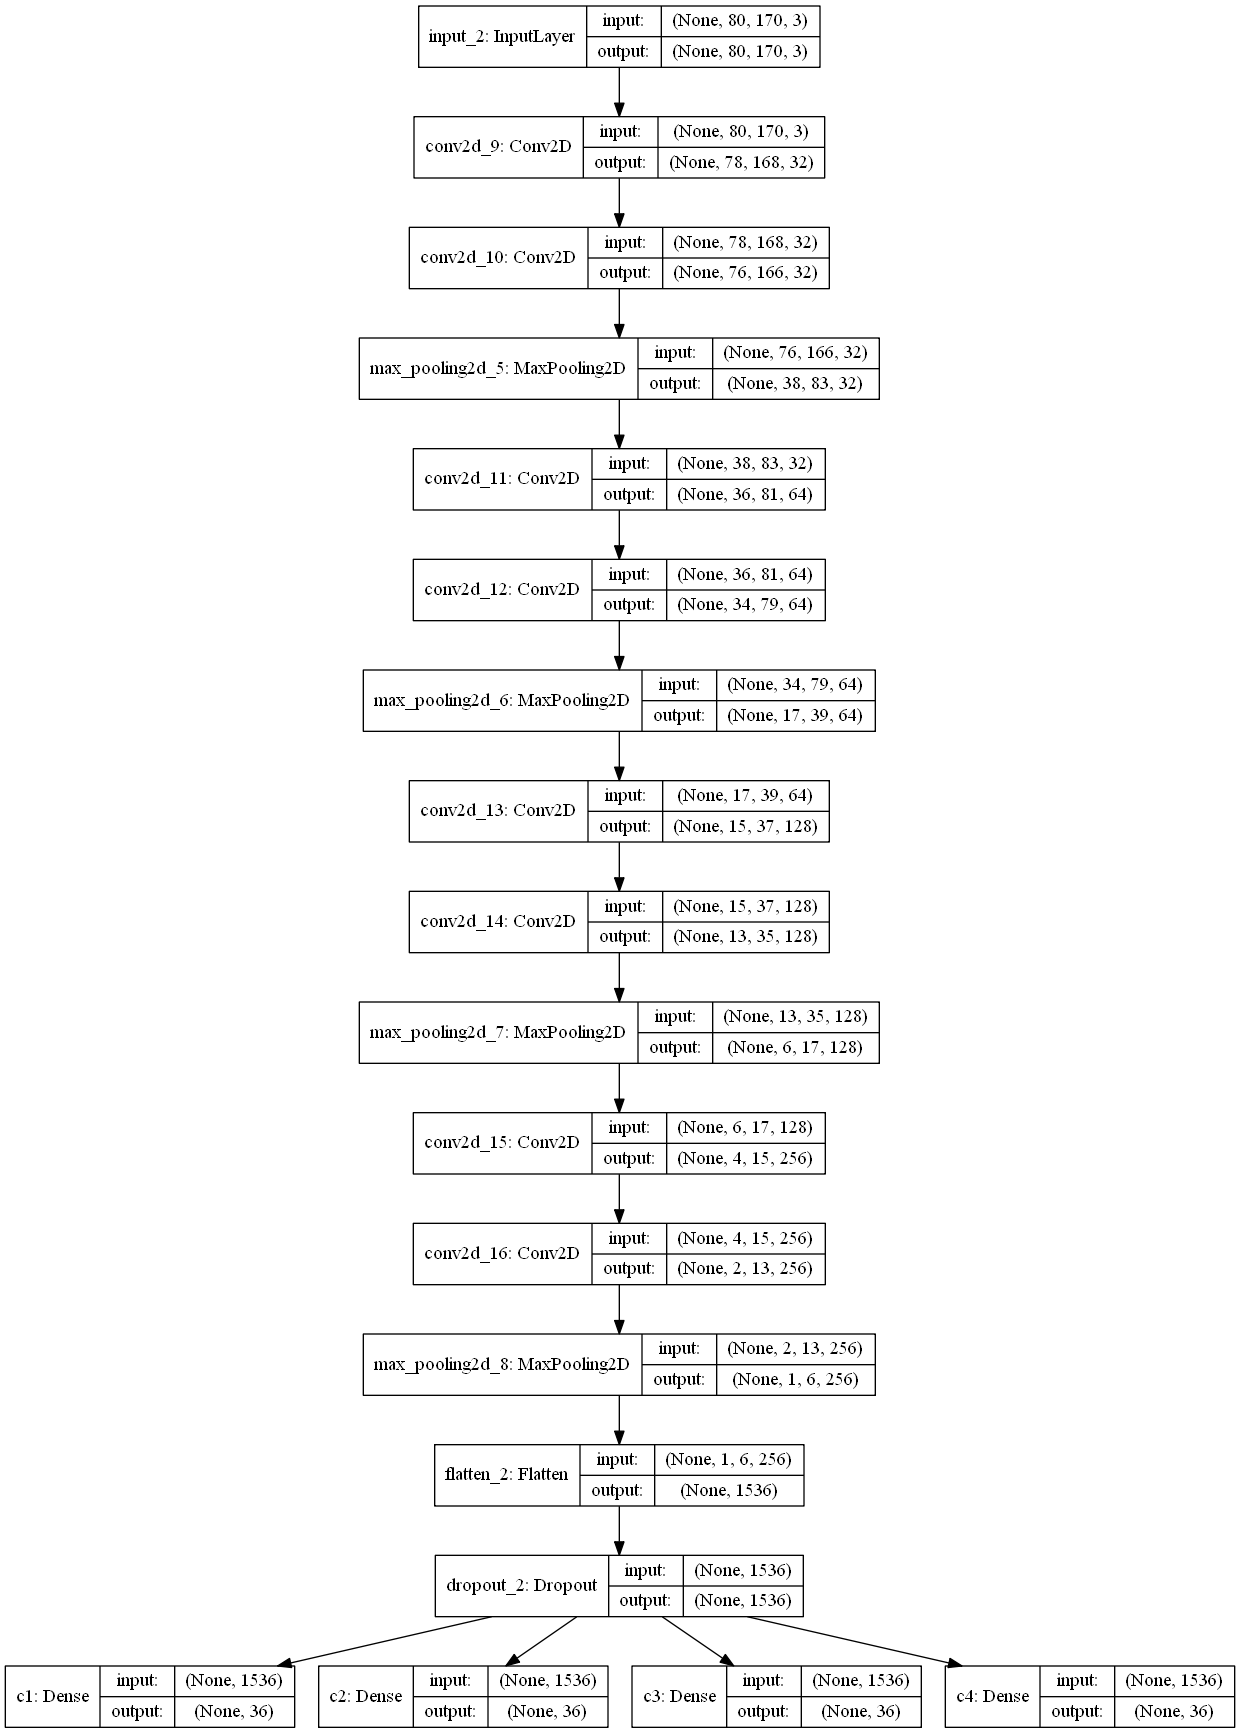

In [25]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image

plot_model(model, to_file="model.png", show_shapes=True)
Image('model.png')

We can see that the shape of the tensor of the output of the last convolutional layer is (1,6,256). We can no longer add convolutions.


## Training
The `model.fit_generator` can be used directly. The verification set here uses the same generator. Since the data is generated randomly by the generator, we do not need to consider whether the data will be duplicated or not.

In [26]:
from keras import callbacks
cbks = [callbacks.ModelCheckpoint("D:/Program/dataset/captcha/best_model.h5", save_best_only=True)]

history = model.fit_generator(gen(batch_size=32),      # Each generator will produce 32 small quantities of data
                    steps_per_epoch=1600,    # Each epoch to train 1,600 batch data
                    epochs=5,                # Run a total of 5 training cycles          
                    callbacks=cbks,          # Save the best model to file
                    validation_data=gen(),   # The verification data is also generated by the generator
                    validation_steps=40      # Use 40 sets of data to verify
                   )

Epoch 1/5
1600/1600 [==============================] - 186s 116ms/step - loss: 14.3849 - c1_loss: 3.5969 - c2_loss: 3.5966 - c3_loss: 3.5952 - c4_loss: 3.5963 - c1_acc: 0.0281 - c2_acc: 0.0276 - c3_acc: 0.0286 - c4_acc: 0.0276 - val_loss: 14.3335 - val_c1_loss: 3.5835 - val_c2_loss: 3.5839 - val_c3_loss: 3.5834 - val_c4_loss: 3.5827 - val_c1_acc: 0.0320 - val_c2_acc: 0.0281 - val_c3_acc: 0.0320 - val_c4_acc: 0.0273
Epoch 2/5
1600/1600 [==============================] - 187s 117ms/step - loss: 6.7346 - c1_loss: 1.9846 - c2_loss: 1.5504 - c3_loss: 1.6644 - c4_loss: 1.5352 - c1_acc: 0.4360 - c2_acc: 0.5480 - c3_acc: 0.5245 - c4_acc: 0.5587 - val_loss: 2.0424 - val_c1_loss: 0.5098 - val_c2_loss: 0.4822 - val_c3_loss: 0.5339 - val_c4_loss: 0.5165 - val_c1_acc: 0.9047 - val_c2_acc: 0.9305 - val_c3_acc: 0.9000 - val_c4_acc: 0.9203
Epoch 3/5
1600/1600 [==============================] - 186s 117ms/step - loss: 0.8522 - c1_loss: 0.2248 - c2_loss: 0.1671 - c3_loss: 0.2545 - c4_loss: 0.2058 - c1_a

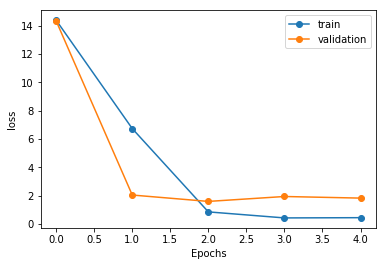

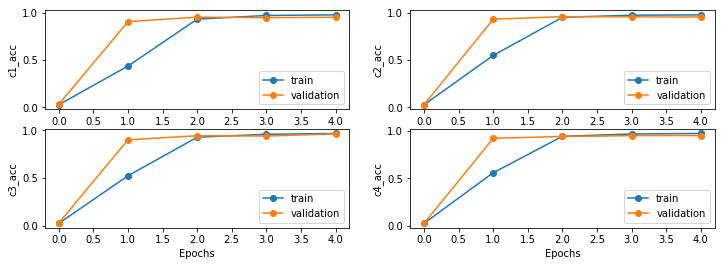

In [27]:
import matplotlib.pyplot as plt

def plot_train_history(history, train_metrics, val_metrics):
    plt.plot(history.history.get(train_metrics),'-o')
    plt.plot(history.history.get(val_metrics),'-o')
    plt.ylabel(train_metrics)
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'])

# Print the overall loss and val_loss
plot_train_history(history, 'loss', 'val_loss')
    
plt.figure(figsize=(12,4))

# The correct rate of the first letter
plt.subplot(2,2,1)
plot_train_history(history, 'c1_acc','val_c1_acc')

# The correct rate of the second letter
plt.subplot(2,2,2)
plot_train_history(history, 'c2_acc','val_c2_acc')

# The correct rate of the third letter
plt.subplot(2,2,3)
plot_train_history(history, 'c3_acc','val_c3_acc')

# The correct rate of the fourth letter
plt.subplot(2,2,4)
plot_train_history(history, 'c4_acc','val_c4_acc')

plt.show()

## Test


In [28]:
from keras.models import load_model

del model  # Remove the model now in memory
model = load_model("D:/Program/dataset/captcha/best_model.h5") # Load the model stored during training

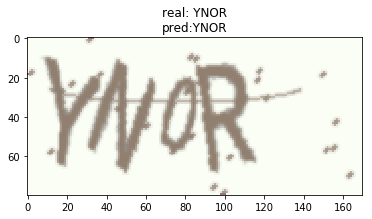

In [29]:
X, y = next(gen(1)) # Produce a new test data
y_pred = model.predict(X) 

plt.title('real: {}\npred:{}'.format(decode(y), decode(y_pred)))
plt.imshow(X[0], cmap='gray')
plt.show()

## Calculate the overall model accuracy

The model will only show the accuracy of each character when training. To calculate the overall accuracy of the model, we can write the following function:

In [30]:
from tqdm import tqdm
def evaluate(model, batch_num=20):
    batch_acc = 0 # The number of correct
    batch_count = 0 # total number
    
    generator = gen()
    for i in tqdm(range(batch_num)):
        X, y = next(generator) # Produce a batch of image information and answers
        y_pred = model.predict(X) 
        y_pred = np.argmax(y_pred, axis=2).T # Transpose matrix (4, 32) -> (32, 4)
        y_true = np.argmax(y, axis=2).T # Transpose matrix (4, 32) -> (32, 4)
        
        # Compared to two matrices is that each cell (character) is the same, 
        # all the same be considered correct
        for i in range(len(y_pred)):
            batch_count += 1
            if np.array_equal(y_true[i], y_pred[i]):
                batch_acc += 1
    # Calculate the correct rate
    return batch_acc / batch_count

# Test the overall accuracy of the model
evaluate(model)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.58it/s]


0.853125

Here is a library called **tqdm**, which is a library of progress bars to provide real-time feedback on program progress.

We use some numpy calculations to calculate our prediction accuracy, where the calculation rule is that as long as there is one error in the four generated values, it is not correct. After calculation, the overall accuracy of our model can reach about 91% after 5 cycles, and further training can achieve higher accuracy.

## Improve

The above model can have very good identification results for a fixed-length captcha, but can not cope with captchas of varying length. If we want to continue improving captchas of indefinite length, we can use recurrent neural networks (RNNs) to recognize sequences of words.

## Reference

[https://ypw.io/captcha/](https://ypw.io/captcha/)

[https://github.com/keras-team/keras/blob/master/examples/image_ocr.py](https://github.com/keras-team/keras/blob/master/examples/image_ocr.py)